### Importing Packages 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Importing Data

In [2]:
# note that train.csv consists of the tabular data. This is what we will read in first
tabular_train = pd.read_csv("../Data/train.csv")
tabular_test = pd.read_csv("../Data/test.csv")

# importing the time series data
# series_train = pd.read_parquet("../Data/series_train.parquet/")
# series_test = pd.read_parquet("../Data/series_test.parquet/")

### Tabular Data 

In [3]:
tabular_train.shape, tabular_test.shape

((3960, 82), (20, 59))

In [4]:
# see which columns are in the train set but not the test set
# store them in case for filtering
response_columns = [col for col in tabular_train.columns.values if col not in tabular_test.columns.values]
covariate_columns = [col for col in tabular_train.columns.values if col in tabular_test.columns.values]

In [5]:
response_columns

['PCIAT-Season',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'sii']

## Sii 
This is our response.

In [60]:
tabular_train['sii'].isna().sum()

1224

In [8]:
# drop all the values with the missing sii cause what the hell is the point
train_data = tabular_train.loc[~tabular_train['sii'].isna(),:]

In [9]:
# we will look at the response first 
train_data['sii'].value_counts()
# most have no sign of any internet abuse
#  look like the data is extremely unbalanced

0.0    1594
1.0     730
2.0     378
3.0      34
Name: sii, dtype: int64

In [10]:
train_data.shape

(2736, 82)

## Basic Data
#### Basic_Demos-Enroll_Season
These are just basic information of the childern. Let's just look at them and see if there is anything interesting.

In [11]:
train_data.isna().sum()

id                                          0
Basic_Demos-Enroll_Season                   0
Basic_Demos-Age                             0
Basic_Demos-Sex                             0
CGAS-Season                               394
                                         ... 
SDS-SDS_Total_Raw                         209
SDS-SDS_Total_T                           211
PreInt_EduHx-Season                        17
PreInt_EduHx-computerinternet_hoursday     82
sii                                         0
Length: 82, dtype: int64

In [12]:
# let's look at the spread of the age
train_data['Basic_Demos-Age'].describe()
# it looks like this a good indicator of age min and max fall between this

count    2736.000000
mean       10.238670
std         3.427982
min         5.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        22.000000
Name: Basic_Demos-Age, dtype: float64

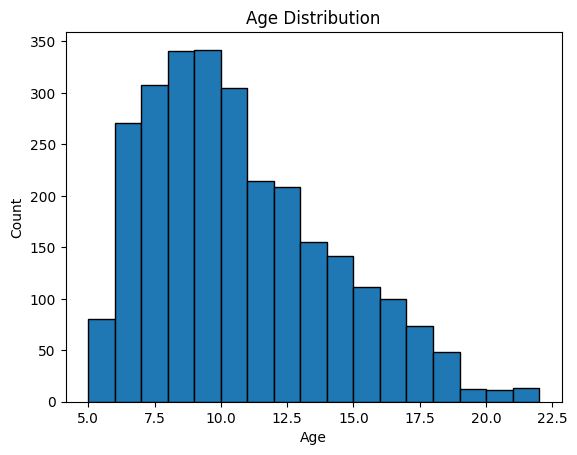

In [13]:
# create a quick histgram for the age to get a good understanding
# of what ages we are dealing with 
plt.hist(train_data['Basic_Demos-Age'], bins=17, edgecolor='black')  # You can adjust 'bins' as needed
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [14]:
# look at the sex now
train_data['Basic_Demos-Sex'].value_counts()
# not really sure what is considerd male or femal this is something we need to figure out

0    1739
1     997
Name: Basic_Demos-Sex, dtype: int64

<Axes: xlabel='Basic_Demos-Age'>

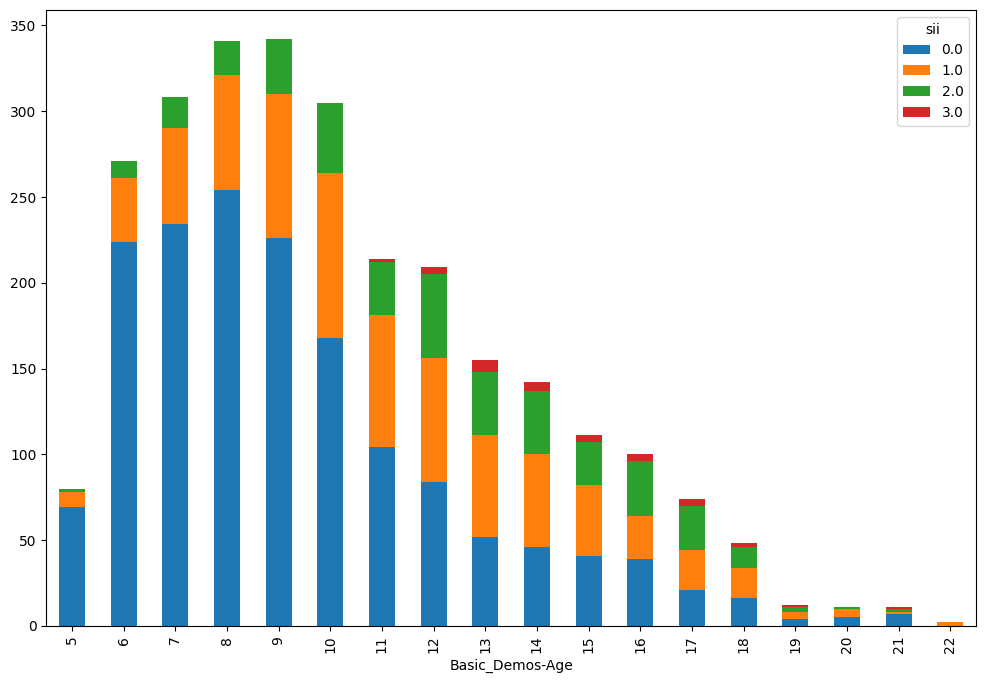

In [16]:
# plot the correlation with the age
train_data.groupby(['Basic_Demos-Age', 'sii']).count()['id'].unstack().plot(kind='bar', stacked=True, figsize=(12, 8))

<Axes: xlabel='Basic_Demos-Age'>

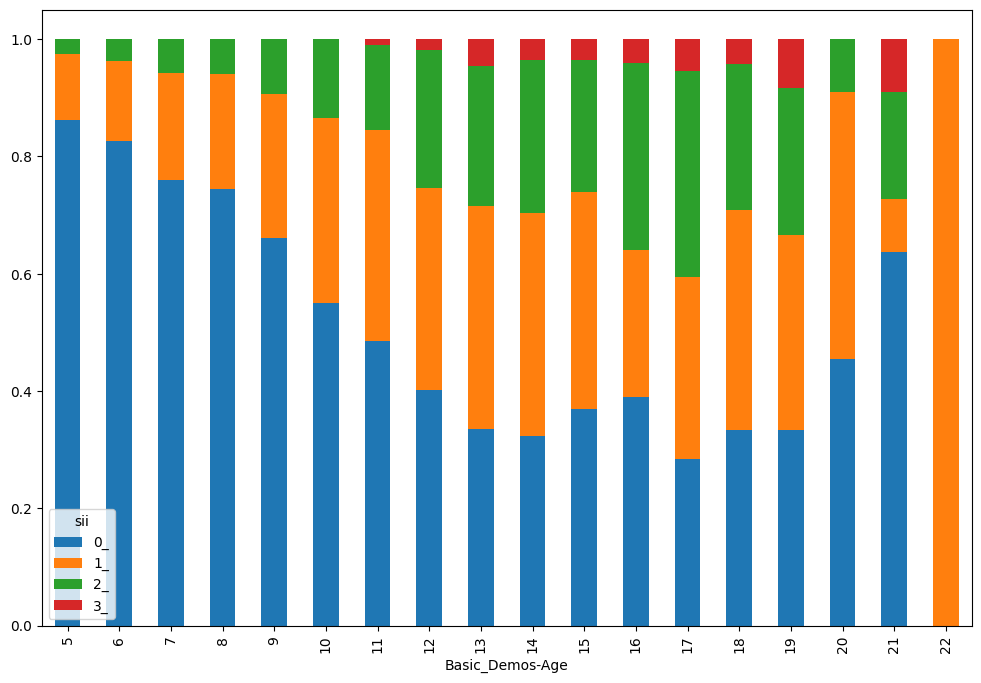

In [17]:
temp = train_data.groupby(['Basic_Demos-Age', 'sii']).count()['id'].unstack()
temp['count'] = train_data['Basic_Demos-Age'].value_counts().sort_index().values
temp['0_'] = temp[0.0] / temp['count']
temp['1_'] = temp[1.0] / temp['count']
temp['2_'] = temp[2.0] / temp['count']
temp['3_'] = temp[3.0] / temp['count']

temp.iloc[:,5:].plot(kind='bar', stacked=True, figsize=(12, 8))

### Cleaning Values
In this section we will look at each of the columns to see if there are values that just make no sense.

#### CGAS_CGAS Score
The Children’s Global Assessment Scale (CGAS), adapted from the Global Assessment Scale for adults, is a rating of general functioning for children and young people aged 4-16 years old. The clinician assesses a range of aspects of psychological and social functioning and gives the child or young person a single score between 1 and 100, based on their lowest level of functioning. The score puts them in one of ten categories that range from “needs constant supervision” (1-10) to “superior functioning” (91-100). The measure can be used by clinicians as well as researchers to complement other scales measuring more specific symptoms.

https://www.corc.uk.net/outcome-experience-measures/childrens-global-assessment-scale-cgas/


The categories for the CGAS-CGAS-score are the following. 

* 1-10: Needs constant supervision (24 hour care)
* 11-20: Needs considerable supervision
* 21-30: Unable to function in almost all areas
* 31-40: Major impairment in functioning in several areas and unable to function in one of these areas
* 41-50: Moderate degree of interference in functioning in most social areas or severe impairment of functioning in one area
* 51-60: Variable functioning with sporadic difficulties or symptoms in several but not all social areas
* 61-70: Some difficulty in a single area, but generally functioning pretty well
* 71-80: No more than slight impairment in functioning
* 81-90: Good functioning in all areas
* 91-100: Superior functioning

What we have to is to create two data set one with the data with only valid ages. Right now there are people with ages that are above 16 which doesnt allign with the documentation above. The other thing we will do is create a column to map the values to their corresponding categories.
The corresponding categories will be

    1.) 1-40 --> disabled

    2.) 41-70 --> moderately impaired
    
    3.) 70+ --> healthy 


In [137]:
train_data["CGAS-CGAS_Score"].isna().sum()

394

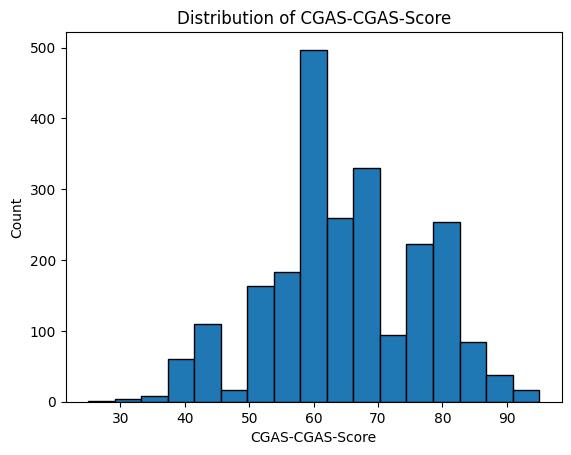

In [22]:
# the range of the values are fine
# lets create a quick histogram about the age s
plt.hist(train_data['CGAS-CGAS_Score'], bins=17, edgecolor='black')  # You can adjust 'bins' as needed
plt.xlabel('CGAS-CGAS-Score')
plt.ylabel('Count')
plt.title('Distribution of CGAS-CGAS-Score')
plt.show()

In [42]:
# we also need to make sure that there are no ages that should not be getting a score that did not. 
train_data.loc[(~train_data['CGAS-CGAS_Score'].isna()) & (train_data['Basic_Demos-Age'] > 16),:].shape

(129, 83)

In [38]:
# we create a new column which changes this columns to the corresponding groups the actually give some context
# Define a function for the mapping the values 
def assign_status(value):
    if pd.isna(value):
        return value
    if value <= 40:
        return 'disabled'
    elif 41 <= value <= 70:
        return 'moderately disabled'
    else:
        return 'healthy'

# Apply the function to create a new column
train_data['CGAS_categorry'] = train_data['CGAS-CGAS_Score'].apply(assign_status)

C:\Users\azpee\AppData\Local\Temp\ipykernel_51164\996036291.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['CGAS_categorry'] = train_data['CGAS-CGAS_Score'].apply(assign_status)


#### Physical Columns

##### Physical-BMI
This value is body mass index for each kid. The values of the BMI can be calculated as 

BMI = weight (kg) / height (m)2

Immediately we notice that some of the BMI's are 0 which makes no sense. We will fill these values in order to change there are only 7 people with this count. We can also try to impute some of the missing values based on the height and the weight with the above formula. 

##### Physical Weight
There are 52 individuals with a weight of 0. We will set all of these to missing as well.

##### Physical-Waist_Circumference
There are too many missing values we are just going to drop this. 

So the first imputation block will be to group Physical-BMI, Physical-Height, and Physical_weight together to see if the values make sense. 

In [58]:
# drop the waist circumference
train_data.drop(columns=['Physical-Waist_Circumference'], inplace = True)

C:\Users\azpee\AppData\Local\Temp\ipykernel_51164\766127127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=['Physical-Waist_Circumference'], inplace = True)


In [46]:
def fill_0_with_NA(val):
    # this will fill the 0s with NA
    if val == 0:
        return np.nan
    else:
        return val

train_data['fixed-Physical-BMI'] = train_data['Physical-BMI'].apply(fill_0_with_NA)
train_data['fixed_Weight'] = train_data['Physical-Weight'].apply(fill_0_with_NA)

C:\Users\azpee\AppData\Local\Temp\ipykernel_51164\1208717403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['fixed-Physical-BMI'] = train_data['Physical-BMI'].apply(fill_0_with_NA)


In [ ]:
# create a data frame to just impute these values
# train_data.loc[:, ['id','fixed-Physical-BMI', 'Physical-Height', 'Physical-Weight']].to_csv('BMI_chunk.csv', index = False)

#### Heart Stuff 
https://www.lovethispic.com/blog/47839/this-blood-pressure-chart-based-on-age-is-something-everyone-should-know-about

The following chart is the what is considerd normal or or high blood presures. 
| Age             | Min     | Normal  | Max      |
|------------------|---------|---------|----------|
| 1-2 years  | 75/50   | 90/60   | 110/75   |
| 1 to 5 years    | 80/55   | 95/65   | 110/79   |
| 6 to 13 years   | 90/60   | 105/70  | 115/80   |
| 14 to 19 years  | 105/73  | 117/77  | 120/81   |
| 20 to 24 years  | 108/75  | 120/79  | 132/83   |

Based on this table we will bin the results together to min normal and max. We will first take out any values that make no sense. For now we will do anything that has a Diastolic blood pressure of more than 83 or less than 50. 

We must also check that the heartrates make sense in the context of the problems. We will follow what the article says
https://health.clevelandclinic.org/pushing-childs-heart-rate-high
We will remove anything less that 60 and anything greater than 140

In [77]:
# this will make something as missing 
# we wil create a function that does this and sets everything to 0
train_data['diastolic_bp'] = train_data['Physical-Diastolic_BP'].apply(lambda x: np.nan if (x < 50) or (x > 83) else x)
train_data['systolic_bp'] = train_data['Physical-Systolic_BP'].apply(lambda x: np.nan if (x < 75) or (x > 132) else x)
train_data['heart_rate'] = train_data['Physical-HeartRate'].apply(lambda x: np.nan if (x < 60) or (x > 140) else x)

C:\Users\azpee\AppData\Local\Temp\ipykernel_51164\1629538943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['diastolic_bp'] = train_data['Physical-Diastolic_BP'].apply(lambda x: np.nan if (x < 50) or (x > 83) else x)
C:\Users\azpee\AppData\Local\Temp\ipykernel_51164\1629538943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['systolic_bp'] = train_data['Physical-Systolic_BP'].apply(lambda x: np.nan if (x < 75) or (x > 132) else x)


In [71]:
# Define function to categorize blood pressure by age group
def categorize_blood_pressure(row):
    if row['Basic_Demos-Age'] <= 1:
        if row['Physical-Systolic_BP'] < 90 or row['Physical-Diastolic_BP'] < 60:
            return 'Low'
        elif 90 <= row['Physical-Systolic_BP'] <= 110 and 60 <= row['Physical-Diastolic_BP'] <= 75:
            return 'Normal'
        else:
            return 'High'
    elif (row['Basic_Demos-Age'] > 1) & (row['Basic_Demos-Age'] <= 5):
        if row['Physical-Systolic_BP'] < 95 or row['Physical-Diastolic_BP'] < 65:
            return 'Low'
        elif 95 <= row['Physical-Systolic_BP'] <= 110 and 65 <= row['Physical-Diastolic_BP'] <= 79:
            return 'Normal'
        else:
            return 'High'
    elif row['Basic_Demos-Age'] <= 13:
        if row['Physical-Systolic_BP'] < 105 or row['Physical-Diastolic_BP'] < 70:
            return 'Low'
        elif 105 <= row['Physical-Systolic_BP'] <= 115 and 70 <= row['Physical-Diastolic_BP'] <= 80:
            return 'Normal'
        else:
            return 'High'
    elif row['Basic_Demos-Age'] <= 19:
        if row['Physical-Systolic_BP'] < 117 or row['Physical-Diastolic_BP'] < 77:
            return 'Low'
        elif 117 <= row['Physical-Systolic_BP'] <= 120 and 77 <= row['Physical-Diastolic_BP'] <= 81:
            return 'Normal'
        else:
            return 'High'
    else:  # 20 to 24 years
        if row['Physical-Systolic_BP'] < 120 or row['Physical-Diastolic_BP'] < 79:
            return 'Low'
        elif 120 <= row['Physical-Systolic_BP'] <= 132 and 79 <= row['Physical-Diastolic_BP'] <= 83:
            return 'Normal'
        else:
            return 'High'

# Apply function to create the new column
train_data['Bloo_ Pressure_Category'] = train_data.apply(categorize_blood_pressure, axis=1)

258

#### Fitness Columns for The Treadmill

 The CV fitness exam was performed by trained health technicians. The protocol is a submaximal exercise test. Based on gender, age, body mass index, and self-reported level of physical activity, participants are assigned to one of eight treadmill test protocols. The goal of each protocol is to elicit a heart rate that is approximately 75 percent of the age-predicted maximum (220-age) by the end of the test. Each protocol includes a 2-minute warm-up, two 3-minute exercise stages, and a 2-minute cool down period.

Note that only some of the kids have had this test taken out on them. We will look at the kids who used this test and try to understand what these columns mean.

##### Fitness_Endurance-Max_Stage

The Fitness_Endurance-Max_Stage column likely refers to the maximum stage or level reached during a treadmill exercise test, such as the Bruce Protocol used in fitness or cardiovascular assessments. In this context, it would represent the highest intensity stage or level the individual completed before reaching their physical limit, typically based on speed and incline during the test. The value could indicate the participant's cardiovascular endurance or fitness level. This value should be from 1-7. We will clip this value to represent this. 

##### Fitness_Endurance-Time_Mins
The Fitness_Endurance-Time_Mins column likely represents the total duration, in minutes, that a participant was able to sustain during the treadmill exercise test based on the NHANES protocol or a similar exercise protocol. This would indicate how long the individual was able to complete the treadmill test, which typically involves gradually increasing intensity until the participant reaches their maximal exertion level. The Higher the better. Time in seconds makes no sense as the values do not line up so we will keep both. 



In [136]:
treadmill_data['Fitness_Endurance-Season'].isna().sum()

0

In [95]:
train_data.loc[:, [col for col in train_data.columns if 'Fitness' in col]].isna().sum() 

Fitness_Endurance-Season       1476
Fitness_Endurance-Max_Stage    2005
Fitness_Endurance-Time_Mins    2008
Fitness_Endurance-Time_Sec     2008
dtype: int64

In [101]:
treadmill_data = train_data.loc[~(train_data['Fitness_Endurance-Max_Stage'].isna()) | 
                                ~(train_data['Fitness_Endurance-Time_Mins'].isna()) | 
                                ~(train_data['Fitness_Endurance-Time_Sec'].isna()), :]

In [105]:
train_data['Clipped_Fitness_Endurance'] = train_data['Fitness_Endurance-Max_Stage'].apply(lambda x: 1 if x == 0 else min(x, 7))

C:\Users\azpee\AppData\Local\Temp\ipykernel_51164\199890196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Clipped_Fitness_Endurance'] = train_data['Fitness_Endurance-Max_Stage'].apply(lambda x: 1 if x == 0 else min(x, 7))


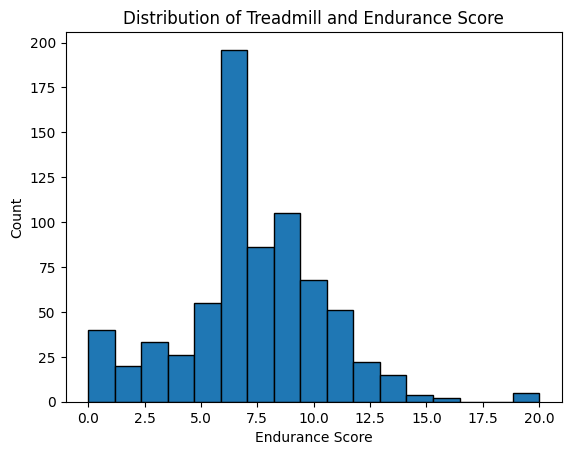

In [111]:
plt.hist(treadmill_data['Fitness_Endurance-Time_Mins'], bins=17, edgecolor='black')  # You can adjust 'bins' as needed
plt.xlabel('Endurance Score')
plt.ylabel('Count')
plt.title('Distribution of Treadmill and Endurance Score')
plt.show()

#### FitnessGram Child
Health related physical fitness assessment measuring five different parameters including aerobic capacity, muscular strength, muscular endurance, flexibility, and body composition.



In [123]:
# grab all the children that had this test don
# we want to grab all the children who took this test 
train_data_fgc = train_data[train_data[[col for col in train_data.columns if 'FGC' in col]].notna().any(axis=1)]


In [127]:
train_data.loc[~train_data['FGC-Season'].isna(), :].shape

(2647, 88)

In [120]:
fitness_gram_data['FGC-FGC_CU']

0        0.0
1        3.0
2       20.0
3       18.0
5       12.0
        ... 
3953     0.0
3954     0.0
3955    16.0
3957    15.0
3958     NaN
Name: FGC-FGC_CU, Length: 2736, dtype: float64

In [138]:
train_data.loc[(~train_data['BIA-Season'].isna()) & (~train_data['FGC-Season'].isna()), :].shape

(1801, 88)

In [129]:
[col for col in train_data.columns if 'BIA' in col]

['BIA-Season',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_Frame_num',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW']

In [134]:
train_data.loc[~train_data['PAQ_A-Season'].isna(), :].shape

(363, 88)

In [133]:
[col for col in train_data.columns if 'PAQ' in col]

['PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total']

In [115]:
treadmill_data[['Fitness_Endurance-Time_Sec','Fitness_Endurance-Time_Mins']]

,Fitness_Endurance-Time_Sec,Fitness_Endurance-Time_Mins
2,33.0,7.0
3,37.0,9.0
15,32.0,5.0
27,45.0,1.0
36,21.0,5.0
...,...,...
3929,19.0,10.0
3930,56.0,12.0
3940,37.0,1.0
3947,20.0,5.0


In [ ]:
# trying the tab2text
def generate_text(row):
    return f"""This individual was enrolled in the study during the {row['Basic_Demos-Enroll_Season']}, 
    a season when their SII response measurement was calculated. They are {row['Basic_Demos-Age']} years old, 
    and their sex is recorded as {row['Basic_Demos-Sex']} (0 represents male, and 1 represents female).

    The child’s global functioning was assessed during {row['CGAS-Season']} 
    using the Children's Global Assessment Scale, with a score of {row['CGAS-CGAS_Score']}, 
    which evaluates the overall level of functioning with a possible range from 1 to 99.

    Physical measurements taken in {row['Physical-Season']} 
    include a Body Mass Index (BMI) of {row['Physical-BMI']} 
    (some measurements may indicate 0.0, which could suggest unavailable or inaccurate data), 
    a height of {row['Physical-Height']} inches, weight of 
    {row['Physical-Weight']} lbs, waist circumference of 
    {row['Physical-Waist_Circumference']} inches, diastolic BP of 
    {row['Physical-Diastolic_BP']} mmHg, heart rate of 
    {row['Physical-HeartRate']} bpm, and systolic BP of 
    {row['Physical-Systolic_BP']} mmHg.

    During the Fitness Endurance assessment in 
    {row['Fitness_Endurance-Season']}, 
    the participant reached a maximum stage of 
    {row['Fitness_Endurance-Max_Stage']} and completed a time of 
    {row['Fitness_Endurance-Time_Mins']} minutes and 
    {row['Fitness_Endurance-Time_Sec']} seconds.
    
    In the FitnessGram test in {row['FGC-Season']}, 
    the participant performed {row['FGC-FGC_CU']} curl-ups, 
    placing them in the {row['FGC-FGC_CU_Zone']} zone (0 indicates "Needs Improvement" and 1 represents the "Healthy Fitness Zone"). 
    Grip strength for both hands was measured, with {row['FGC-FGC_GSND']} for the non-dominant hand 
    and they fell in the ({row['FGC-FGC_GSND_Zone']}, where 1 is "Weak," 2 is "Normal," and 3 is "Strong"). 
    Grip strength was {row['FGC-FGC_GSD']} for the dominant hand 
    and they fell into {row['FGC-FGC_GSD_Zone']}. 
    Push-up and flexibility measurements showed a push-up total of {row['FGC-FGC_PU']}
    which fell into the {row['FGC-FGC_PU_Zone']} which indicates the fitness level, 0 for "Needs Improvement" and 1 for "Healthy Fitness Zone").
    Additional flexibility tests for the left and right sides were {row['FGC-FGC_SRL']} and {row['FGC-FGC_SRR']} respectively, 
    with zones recorded as {row['FGC-FGC_SRL_Zone']} and {row['FGC-FGC_SRR_Zone']} for the left and right side respectively. 
    The trunk lift score was {row['FGC-FGC_TL']}, and their fitness zone for trunk lift was {row['FGC-FGC_TL_Zone']}.

    The participant’s body composition was analyzed through Bio-electric Impedance Analysis (BIA) during {row['BIA-Season']}. 
    Key measures include their activity level of {row['BIA-BIA_Activity_Level_num']} (where 1 is "Very Light" and 5 is "Exceptional"),
    a body fat percentage of {row['BIA-BIA_Fat']}, 
    a bone mineral content of {row['BIA-BIA_BMC']}, 
    a BMI of {row['BIA-BIA_BMI']}, 
    and their total body water (TBW) recorded as {row['BIA-BIA_TBW']}. 
    Other BIA metrics include basal metabolic rate (BMR) of {row['BIA-BIA_BMR']}, 
    daily energy expenditure (DEE) of {row['BIA-BIA_DEE']}, 
    extracellular water (ECW) of {row['BIA-BIA_ECW']}, 
    fat-free mass (FFM) of {row['BIA-BIA_FFM']}, 
    fat mass index (FMI) of {row['BIA-BIA_FMI']}, 
    and skeletal muscle mass (SMM) of {row['BIA-BIA_SMM']}.

    Activity levels from the Physical Activity Questionnaire for Adolescents (PAQ-A) and Children (PAQ-C) were recorded during {row['PAQ_A-Season']} 
    and {row['PAQ_C-Season']}, 
    showing scores of {row['PAQ_A-PAQ_A_Total']} 
    and {row['PAQ_C-PAQ_C_Total']} respectively, summarizing the overall physical activity level for each age group.

    The Sleep Disturbance Scale (SDS) in {row['SDS-Season']} 
    recorded a total raw score of {row['SDS-SDS_Total_Raw']} 
    and a standardized T-score of {row['SDS-SDS_Total_T']}

    Finally, computer and internet usage data for {row['PreInt_EduHx-Season']} 
    shows that this participant spends {row['PreInt_EduHx-computerinternet_hoursday']} 
    hours per day online (0 = Less than 1h/day, 1 = Around 1h/day, 2 = Around 2h/day, 3 = More than 3h/day).
    """


In [101]:
text_column = [generate_text(without_survey.loc[row,:]) for row in range(without_survey.shape[0])]

In [104]:
without_survey['text_column'] = text_column

In [113]:
without_survey['clean_text'] = [without_survey['text_column'][i].replace('\n',' ').replace('      ', ' ').replace('     ',' ') for i in range(without_survey.shape[0])]

In [115]:
without_survey['clean_text'][0]

'This individual was enrolled in the study during the Fall, a season when their SII response measurement was calculated. They are 5 years old, and their sex is recorded as 0 (0 represents male, and 1 represents female). The child’s global functioning was assessed during Winter using the Children\'s Global Assessment Scale, with a score of 51.0, which evaluates the overall level of functioning with a possible range from 1 to 99. Physical measurements taken in Fall include a Body Mass Index (BMI) of 16.87731569 (some measurements may indicate 0.0, which could suggest unavailable or inaccurate data), a height of 46.0 inches, weight of 50.8 lbs, waist circumference of nan inches, diastolic BP of nan mmHg, heart rate of nan bpm, and systolic BP of nan mmHg. During the Fitness Endurance assessment in nan, the participant reached a maximum stage of nan and completed a time of nan minutes and nan seconds. In the FitnessGram test in Fall, the participant performed 0.0 curl-ups, placing them in 

In [116]:
without_survey.to_csv("data_with_text.csv")